In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from typing import Tuple
from dataclasses import dataclass
from datetime import datetime
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

from PIL import Image
from IPython import display

In [2]:
# Parametri okruzenja
MASTER_FOLDER = 'cyclegan' # Folder gde se cuvaju svi rezultati
BATCH_SIZE = 40 
IMG_SIZE = 32 # Pozeljno je da dimenzija slike bude stepen dvojke zbog U-NET modela
IMG_CHANNELS = 1
SKUP_PODATAKA = 'mnist' # 'fashion_mnist'

In [3]:
from library.mnist import prepare_mnist_dataset
tf_train, tf_test = prepare_mnist_dataset('mnist')

In [4]:
def create_dataset(tf_data):
    tf_data = tf_data.map(lambda _, x: (x, 1-x))
    tf_data_x = tf_data.map(lambda x, y: x)
    tf_data_y = tf_data.map(lambda x, y: y)
    tf_data_y = tf_data_y.shuffle(400)
    return tf.data.Dataset.zip((tf_data_x, tf_data_y))

tf_train_contrast = create_dataset(tf_train)
tf_test_contrast = create_dataset(tf_test)

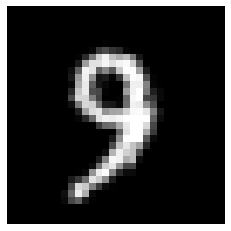

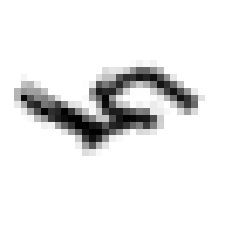

In [5]:
from library.visualization import show_image
for x, y in tf_train_contrast.take(1):
    show_image(x[5])
    show_image(y[5])

In [6]:
from library.unet_generator import UNetGeneratorBuilder

def create_generator(*args, **kwargs):
    generator_builder = UNetGeneratorBuilder(*args, **kwargs)
    generator_builder.add_downsample_layer(16, 3, apply_batchnorm=True)
    generator_builder.add_downsample_layer(32, 3)
    generator_builder.add_upsample_layer(16, 3, apply_dropout=True)
    return generator_builder.build()

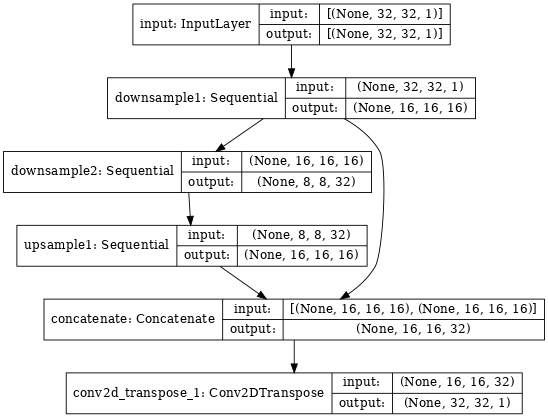

In [7]:
generator_g = create_generator(input_size=IMG_SIZE, output_channels=IMG_CHANNELS)
generator_f = create_generator(input_size=IMG_SIZE, output_channels=IMG_CHANNELS)
keras.utils.plot_model(generator_g, show_shapes=True, dpi=64)

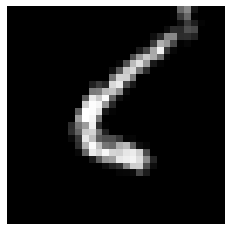

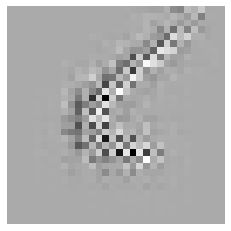

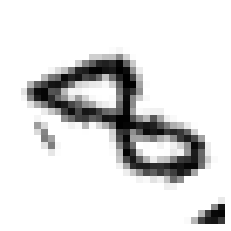

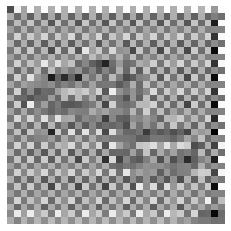

In [8]:
for x, y in tf_train_contrast.take(1):
    show_image(x[3])
    show_image(generator_g(x)[3])
    show_image(y[3])
    show_image(generator_f(y)[3])

In [9]:
from library.unet_generator import downsample

def create_discriminator(input_size: int):
    """
    Diskriminator se sastoji iz niza "downsample" slojeva.
    Napomena: Diskriminator ocenjuje nekoliko ravnomerno rasporedjenih kvadrata na slici
    i za svaki govori da li je slika prava ili ne. 

    :param input_size: Dimenzija ulazne slike
    :return: Diskriminator
    """
    inputs = layers.Input(shape=[input_size, input_size, 1], name='disc_input')
    target = layers.Input(shape=[input_size, input_size, 1], name='disc_target')

    x = layers.concatenate([inputs, target])

    x = downsample(16, 4, apply_batchnorm=False)(x)
    x = downsample(32, 4)(x)
    x = layers.Conv2D(1, 4, strides=1)(x)
    x = layers.Conv2D(1, 4, strides=1)(x)

    return keras.Model(inputs=[inputs, target], outputs=x)

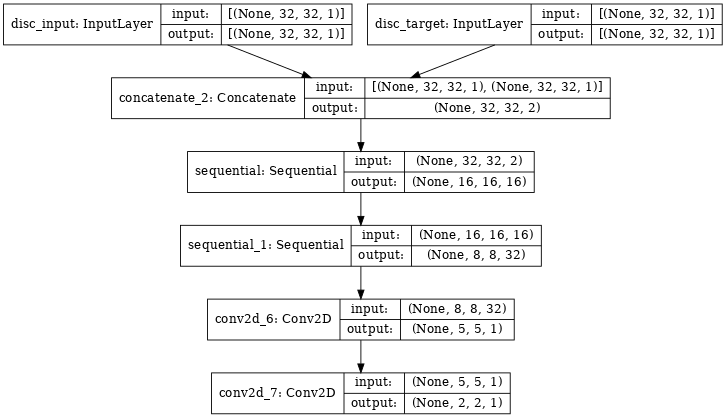

In [10]:
discriminator_x = create_discriminator(input_size=IMG_SIZE)
discriminator_y = create_discriminator(input_size=IMG_SIZE)
keras.utils.plot_model(discriminator_x, show_shapes=True, dpi=64)

In [11]:
# Podesavanje optimizatora
generator_f_optimizer = tf.keras.optimizers.Adam(1e-2, beta_1=0.5)
generator_g_optimizer = tf.keras.optimizers.Adam(1e-2, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(1e-2, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(1e-2, beta_1=0.5)

In [12]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

disc_alpha = 5
gen_alpha = 5
cycle_alpha = 7
identity_beta = 1.5

def discriminator_loss(real_images, generated_images):
    real_loss = bce(tf.ones_like(real_image), real_image)
    gen_loss = bce(tf.zeros_like(generated_image), generated_imge)
    return (real_loss + gen_loss) * disc_alpha
    
def generator_loss(generated_images):
    return bce(tf.ones_like(generated_images), generated_images) * gen_alpha

def cycle_loss(real_images, cycled_images):
    return tf.reduce_mean(tf.abs(real_images - cycled_images)) * cycle_alpha

def identity_loss(real_images, generated_image_of_same_type):
    return tf.reduce_mean(tf.abs(real_image - generated_image_of_same_type)) * cycle_alpha * identity_beta

In [13]:
# Podesavanje logovanja
summary_writer = tf.summary.create_file_writer(f'{MASTER_FOLDER}/logs/fit/{datetime.now().strftime("%Y%m%d-%H%M%S")}')

In [14]:
# Podesavanje parametara za periodicnog cuvanja stanja modela
checkpoint_dir = f'{MASTER_FOLDER}/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

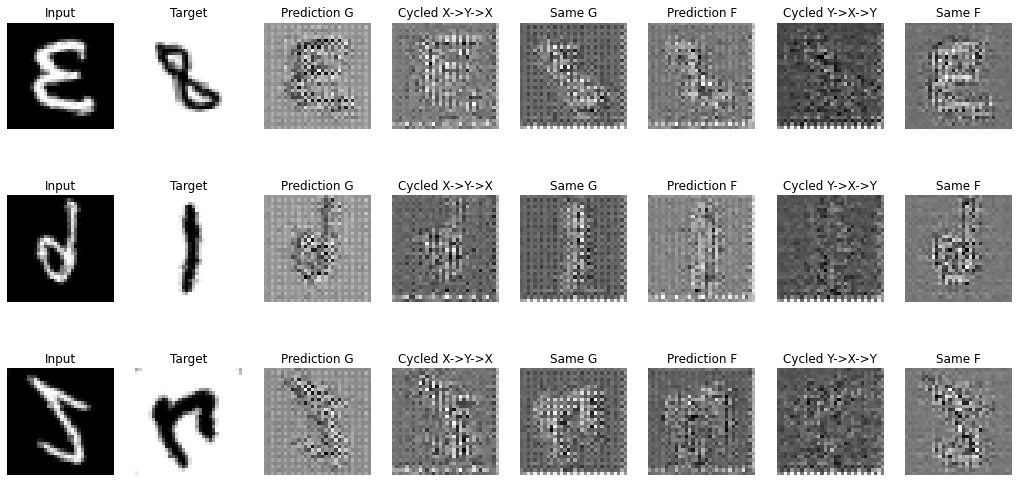

In [15]:
def test_image_generation(gen_g, gen_f, input_batch, target_batch, img_size, rows=3):
    """
    Pomocna funkcija za vizualizaciju perfomansi modela.
    :param gen_g: G Generator
    :param gen_f: F Generator
    :param input_batch: Ulaz (slike sa postavljenim kvadratom)
    :param target_batch: Izlaz (prave slike)
    :param img_size: Dimenzija slike koja se prikazuje
    :param rows: Broj primera koji se prikazuju
    :return: None
    """
    assert rows <= input_batch.shape[0]
    prediction_batch_g = gen_g(input_batch, training=True)
    prediction_batch_f = gen_f(target_batch, training=True)
    cycled_batch_gf = gen_f(prediction_batch_g, training=True)
    cycled_batch_fg = gen_g(prediction_batch_f, training=True)
    same_batch_g = gen_g(target_batch, training=True)
    same_batch_f = gen_f(input_batch, training=True)
    channels = input_batch.shape[-1]

    fig, axs = plt.subplots(figsize=(18, 3 * rows), ncols=8, nrows=rows)
    for i in range(rows):
        pg_img = prediction_batch_g[i]
        pf_img = prediction_batch_f[i]
        i_img = input_batch[i]
        t_img = target_batch[i]
        cg_img = cycled_batch_gf[i]
        cf_img = cycled_batch_fg[i]
        sg_img = same_batch_g[i]
        sf_img = same_batch_f[i]
        for j, (img, title) in enumerate([(i_img, 'Input'), (t_img, 'Target'), 
                                          (pg_img, 'Prediction G'), (cg_img, 'Cycled X->Y->X'),
                                          (sg_img, 'Same G'), (pf_img, 'Prediction F'), 
                                          (cf_img, 'Cycled Y->X->Y'), (sf_img, 'Same F'),]):
            new_shape = img_size, img_size, channels
            if channels == 1:
                new_shape = new_shape[:-1]
            img_reshaped = tf.reshape(img, shape=new_shape)
            axs[i][j].imshow(img_reshaped, cmap='gray')
            axs[i][j].set_title(title)
            axs[i][j].axis('off')
    plt.show()
    
for x, y in tf_train_contrast.take(1):
    test_image_generation(generator_g, generator_f, x, y, img_size=IMG_SIZE)

In [16]:
class CycleGAN:
    def __init__(self, gen_g, gen_f, 
                 disc_x, disc_y, 
                 gen_g_optim, gen_f_optim, 
                 disc_x_optim, disc_y_optim,
                 img_size,
                 summary_writer=None,
                 checkpoint=None,
                 checkpoint_prefix=None
                ):
        self.gen_g = gen_g
        self.gen_f = gen_f
        self.disc_x = disc_x
        self.disc_y = disc_y
        
        self.gen_g_optim = gen_g_optim
        self.gen_f_optim = gen_f_optim
        self.disc_x_optim = disc_x_optim
        self.disc_y_optim = disc_y_optim
        
        self.img_size = img_size
        
        self.summary_writer = summary_writer
        self.checkpoint = checkpoint
        self.checkpoint_prefix = checkpoint_prefix
        
    @tf.function
    def train_step(self, real_images_x, real_images_y):
        with tf.GradientTape(persistent=True) as tape:
            fake_images_y = gen_g(real_images_x)
            fake_images_x = gen_f(real_images_y)
            
            cycled_images_x = gen_f(fake_images_y)
            cycled_images_y = gen_g(fake_images_x)
            
            same_images_x = gen_f(real_images_x)
            same_images_y = gen_g(real_images_y)
            
            disc_real_images_x = disc_x(real_images_x)
            disc_real_images_y = disc_y(real_images_y)
            
            disc_fake_images_x = disc_x(fake_images_x)
            disc_fake_images_y = disc_y(fake_images_y)
            
            gen_g_loss = generator_loss(disc_fake_images_y)
            gen_f_loss = generator_loss(disc_fake_images_x)
            
            disc_x_loss = discriminator_loss(disc_real_images_x, disc_fake_images_x)
            disc_y_loss = discriminator_loss(disc_real_images_y, disc_fake_images_y)
            
            cycle_x_loss = cycle_loss(real_images_x, cycled_images_x)
            cycle_y_loss = cycle_loss(real_images_y, cycled_images_y)
            total_cycled_loss = cycle_x_loss + cycle_y_loss
            
            identity_x_loss = identity_loss(real_images_x, same_images_x)
            identity_y_loss = identity_loss(real_images_y, same_images_y)
            
            total_gen_g_loss = gen_g_loss + total_cycled_loss + identity_y_loss
            total_gen_f_loss = gen_f_loss + total_cycled_loss + identity_x_loss
            
        # Calculate the gradients for generator and discriminator
        gen_g_gradients = tape.gradient(total_gen_g_loss, self.gen_g.trainable_variables)
        gen_f_gradients = tape.gradient(total_gen_f_loss, self.gen_f.trainable_variables)

        disc_x_gradients = tape.gradient(disc_x_loss, self.disc_x.trainable_variables)
        disc_y_gradients = tape.gradient(disc_y_loss, self.disc_y.trainable_variables)

        # Apply the gradients to the optimizer
        self.gen_g_optimizer.apply_gradients(zip(gen_g_gradients, self.gen_g.trainable_variables))
        self.gen_f_optimizer.apply_gradients(zip(gen_f_gradients, self.gen_f.trainable_variables))

        self.disc_x_optimizer.apply_gradients(zip(disc_x_gradients, self.disc_x.trainable_variables))
        self.disc_y_optimizer.apply_gradients(zip(disc_y_gradients, self.disc_y.trainable_variables))
        
    def fit(self,
            train_ds,
            val_ds,
            steps,
            test_generation_period=1000,
            n_test_examples=4,
            checkpoint_period=5000):
        """
        Napomena: Namera je da se funkcija koristi u okviru IPython sveske

        Proces ucenja zasnovan na funkciji "train_step" koji dodatno:
        - prikazuje rezultate;
        - ispisuje stanje ucenja;
        - Kreira periodicno checkpoint.

        :param train_ds: Skup za treniranje
        :param val_ds: Skup za validaciju
        :param steps: Broj koraka treniranja
        :param test_generation_period: Broj koraka izmedju vizualizacije novih rezultata
        :param n_test_examples: Broj instanci koje se vizualizuju
        :param checkpoint_period: Period za cuvanje rezultata
        :return: Loss History
        """
        dot_period = test_generation_period // 10
        example_input, example_target = next(iter(val_ds.take(n_test_examples)))
        start = time.time()

        for step, (input_image, target) in train_ds.repeat().take(steps+1).enumerate():
            if (step+1) % test_generation_period == 0:
                display.clear_output(wait=True)

                if step != 0:
                    print(f'Time taken for {step+1} steps: {time.time()-start:.2f} sec\n')

                test_image_generation(
                    self.gen_g, self.gen_f, 
                    example_input, example_target, 
                    rows=n_test_examples, img_size=self.img_size
                )
                print(f"Step: {step+1}")

            # Training step
            if (step+1) % dot_period == 0:
                print('.', end='', flush=True)

            # Save (checkpoint) the model every 5k steps
            if self.checkpoint is not None and (step + 1) % checkpoint_period == 0:
                self.checkpoint.save(file_prefix=self.checkpoint_prefix)

Time taken for 100000 steps: 1992.34 sec



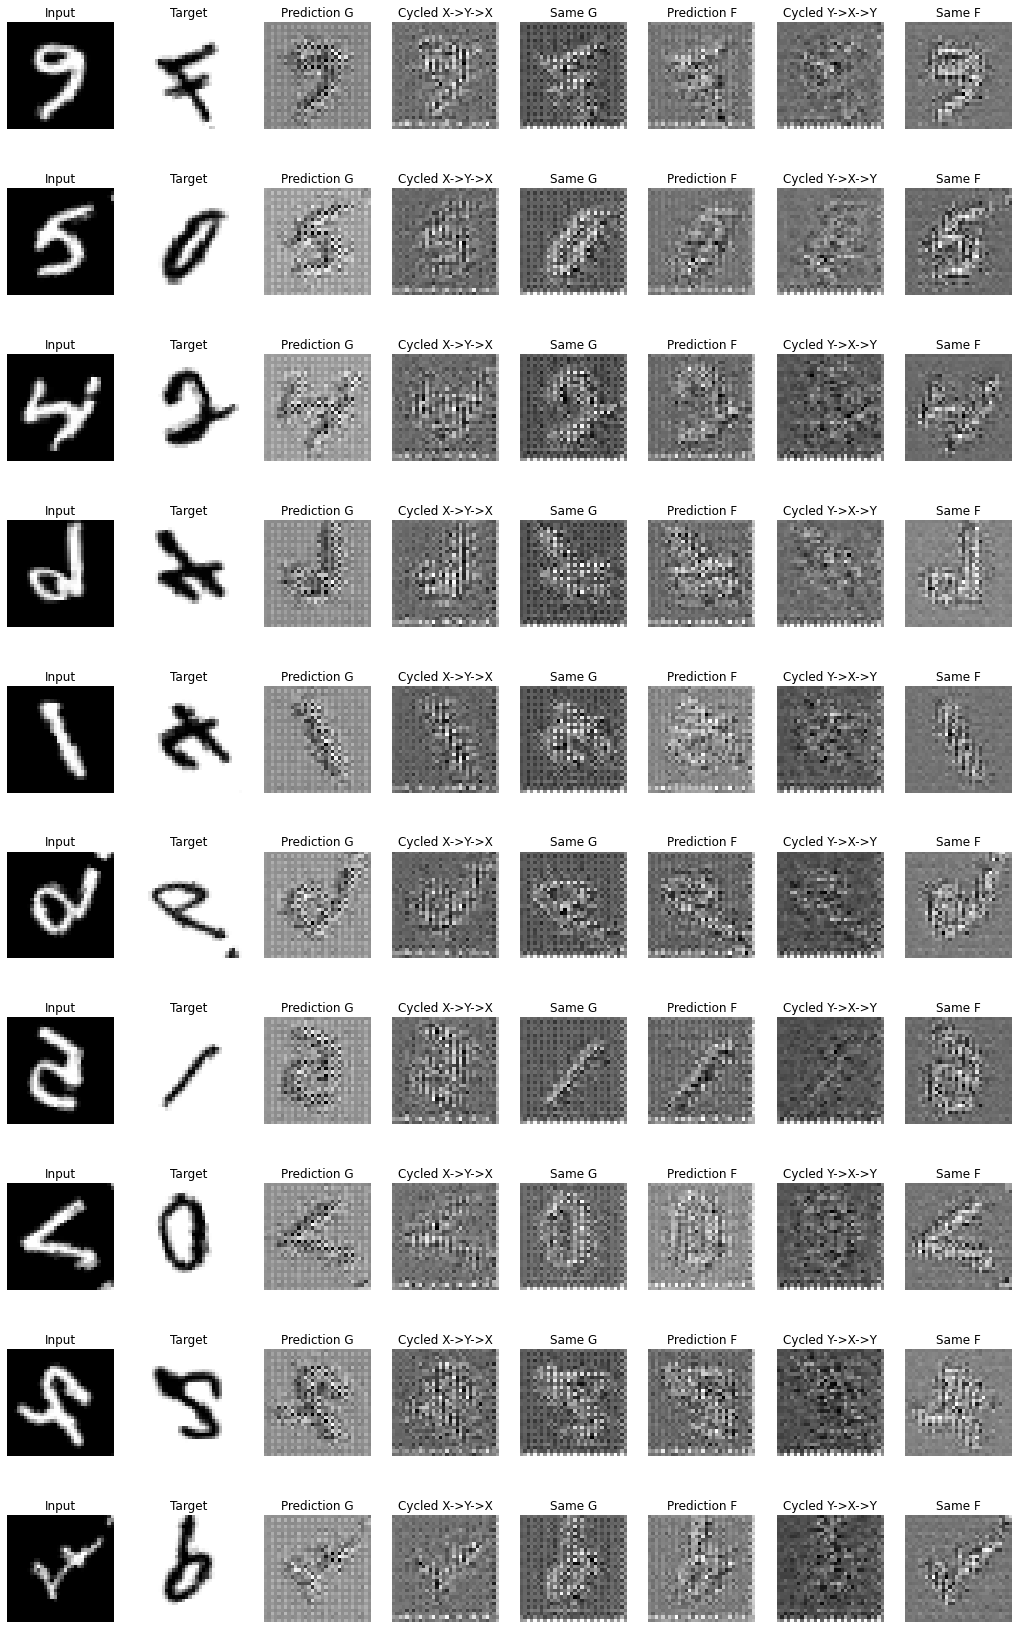

Step: 100000
.

In [17]:
cyclegan = CycleGAN(
    gen_g = generator_g,
    gen_f = generator_f,
    disc_x = discriminator_x,
    disc_y = discriminator_y,
    gen_g_optim = generator_g_optimizer,
    gen_f_optim = generator_f_optimizer,
    disc_x_optim = discriminator_x_optimizer,
    disc_y_optim = discriminator_y_optimizer,
    summary_writer = summary_writer,
    checkpoint = checkpoint,
    checkpoint_prefix = checkpoint_prefix,
    img_size=IMG_SIZE
)

cyclegan.fit(tf_train_contrast, tf_test_contrast, steps=100000, test_generation_period=5000, n_test_examples=10)